# Load required pakages

In [1]:
from sklearn.model_selection import RepeatedKFold,cross_validate,cross_val_score,train_test_split,StratifiedKFold,RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer,\
                            LabelEncoder, MinMaxScaler,StandardScaler

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE,SVMSMOTE,RandomOverSampler,BorderlineSMOTE,ADASYN
from sklearn.naive_bayes import BernoulliNB,GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn import set_config
set_config(display='diagram')


import csv
import plotly.graph_objects as go
import plotly
import plotly.express as px
from plotly.subplots import make_subplots

import pandas as pd
import matplotlib.pyplot as plt
from numpy import mean,std,where
import numpy as np
from collections import Counter

import warnings, os, pickle,joblib
warnings.filterwarnings("ignore")
rs=10
np.random.seed(10)


colorsScale=['#0173B2',
 '#DE8F05',
 '#029E73',
 '#D55E00',
 '#CC78BC',
 '#CA9161',
 '#FBAFE4',
 '#949494',
 '#ECE133',
 '#56B4E9']


# Define required functions

In [8]:
############################## define models to test    ##############################
def get_models():
    models, names = list(), list()
    
    # 1. Linear Algorithms
 	#LR
    models.append(LogisticRegression(random_state=rs))
    names.append('LR')
    
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    
    models.append(GaussianNB())
    names.append('GNB')
    
    #2. Nonlinear Algorithms
 	# SVM
    models.append(LinearSVC(random_state=rs))
    names.append('SVM')
    
 	 # # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
      
    models.append(DecisionTreeClassifier())
    names.append('DTC')
      
    #3. Ensemble Algorithms
      
    models.append(RandomForestClassifier(n_estimators = 10, random_state = rs))
    names.append('RF')
      
    models.append(BaggingClassifier(n_estimators = 10,random_state = rs))
    names.append('BC')
      
    models.append(ExtraTreesClassifier(n_estimators = 10,random_state = rs))
    names.append('ETC')
      
    models.append(GradientBoostingClassifier(n_estimators = 10,random_state = rs))
    names.append('GBC')
   
    models.append(GaussianProcessClassifier(random_state=rs))
    names.append('GP')
      
    models.append(DummyClassifier(strategy='uniform',random_state=rs))
    names.append('Dummy')
    
    return models, names


############################## define sampling to test ##############################
def get_OST():
    models, names = list(), list()
    	
    models.append(BorderlineSMOTE(k_neighbors=2,random_state=rs))
    names.append('BorderlineSMOTE')
    
    models.append(SVMSMOTE(k_neighbors=3,random_state=rs))
    names.append('SVMSMOTE')
    
    models.append(RandomOverSampler(random_state=rs))
    names.append('RandomOverSampler')
    
    return models, names
    
    
    ############################## run classifiers ##############################

def runClassifier(X_mat, y_var):

    #define over sampling techniques
    ost, names_OST=get_OST()

    # define models
    models, names_MODEL = get_models()
    
    #to save results
    results = {"Acc":[],"Bal_acc":[],"F1":[],"model":[],"precision":[],
               "average_precision":[],"recall":[],"roc_auc":[]}
    nested_results = {"Acc":[],"Bal_acc":[],"F1":[],"model":[],"precision":[],
                      "average_precision":[],"recall":[],"roc_auc":[]}
    cv={}
    
    #performance evaluation metrices
    scoring = ['accuracy',"balanced_accuracy","f1",'recall',"precision","average_precision","roc_auc"]
    rkf = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=rs)   

    print("Avearge precision from RSKF CV : ")
    # evaluate each model
    for i in range(len(models)):   
        
        # evaluate each oversampling method
        for j in range(len(ost)):
 
            print("\n***************************\n"+ names_MODEL[i]+"   "+names_OST[j]+"\n***************************")

                        # create pipeline

            pipeline = Pipeline_imb(steps=[('o',ost[j]),
                                           ("rfecv" , RFECV(estimator=LogisticRegression(random_state=rs),min_features_to_select=3,cv=rkf)),
                                           ('m', models[i])])
            # estimators for rfecv
            param_grid = {'rfecv__estimator':[LinearDiscriminantAnalysis(),
                                             LinearSVC(random_state=rs)]}

            
                        # evaluate the model with grid search cv
            CV = GridSearchCV(estimator=pipeline, param_grid=param_grid,refit="average_precision",scoring = scoring,cv=rkf,n_jobs=-1)
            
                        ####      nested   CV
            nested_scores = cross_validate(CV, X_mat, y_var, scoring=scoring, cv=rkf, n_jobs=-1)

            nested_results["Acc"].append(np.around(mean(nested_scores["test_accuracy"])  ,3))        
            nested_results["Bal_acc"].append(np.around(mean(nested_scores["test_balanced_accuracy"])  ,3))

            nested_results["F1"].append(np.around(mean(nested_scores["test_f1"]),3))
            nested_results["recall"].append(np.around(mean(nested_scores["test_recall"]),3))
            nested_results["average_precision"].append(np.around(mean(nested_scores["test_average_precision"]),3))

            nested_results["precision"].append(np.around(mean(nested_scores["test_precision"]),3))

            nested_results["roc_auc"].append(np.around(mean(nested_scores["test_roc_auc"]),3))
            nested_results["model"].append(names_MODEL[i]+"__"+names_OST[j])
            
                       ####      RSKF  CV
            CV.fit(X_mat, y_var)
            print(CV.best_score_) 
            
            rank=list(CV.cv_results_["rank_test_average_precision"]).index(1)
            
            results["Acc"].append(np.around(CV.cv_results_["mean_test_accuracy"][rank]  ,3))        
            results["Bal_acc"].append(np.around(CV.cv_results_["mean_test_balanced_accuracy"][rank]  ,3))

            results["F1"].append(np.around(CV.cv_results_["mean_test_f1"][rank],3))
            results["precision"].append(np.around(CV.cv_results_["mean_test_precision"][rank],3))
            results["average_precision"].append(np.around(CV.cv_results_["mean_test_average_precision"][rank],3))

            results["recall"].append(np.around(CV.cv_results_["mean_test_recall"][rank],3))

            results["roc_auc"].append(np.around(CV.cv_results_["mean_test_roc_auc"][rank],3))
            results["model"].append(names_MODEL[i]+"__"+names_OST[j])
            
            cv[names_MODEL[i]+"__"+names_OST[j]]=CV
  
    return(results,nested_results,cv)


# Read Input data as a pandas dataframe

In [3]:
# setup the working directory
#os.chdir("dir/with/input/data")

# read input file
complete_data=pd.read_csv("P,DO,C_PCR_log2FC_imputed.csv")
complete_data=complete_data.set_index('ID')
complete_data=complete_data.drop(columns = "patient")

# Class distribution

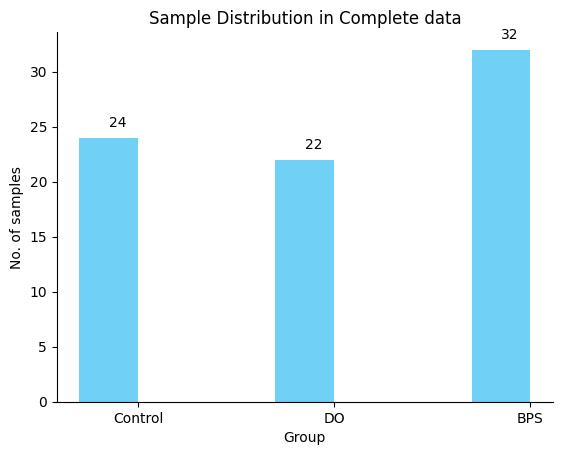

In [4]:
labels, values = zip(*Counter(complete_data["diagnosis"]).items())
indexes = np.arange(len(labels))
plt.bar(indexes, values,  0.3,color ="#71D0F5FF" , align='center')
plt.xticks(indexes + 0.3 * 0.5, labels)
for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10))
    
plt.xlabel("Group")
plt.ylabel("No. of samples")
plt.title("Sample Distribution in Complete data")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig("sampDist.pdf",format="pdf")
plt.show()

# Convert multiclassification problem into binary classification problem

In [5]:

                    ##############################
                    ####### Pain Vs Control ######
                    ##############################
bps_control=complete_data.loc[complete_data['diagnosis'] != 'DO']
X_pain_control= bps_control.iloc[:,1:]
y_pain_control = bps_control["diagnosis"]
y_pain_control = LabelEncoder().fit_transform(y_pain_control)


                    ##############################
                    #######   DO Vs Control ######
                    ##############################
do_control=complete_data.loc[complete_data['diagnosis'] != 'BPS']
X_DO_C= do_control.iloc[:,1:]
y_DO_C = do_control["diagnosis"]
y_DO_C = LabelEncoder().fit_transform(y_DO_C)

                    ##############################
                    #######   pain Vs DO ######
                    ##############################
bps_do=complete_data.loc[complete_data['diagnosis'] != 'Control']
X_BPS_DO= bps_do.iloc[:,1:]
y_BPS_DO = bps_do["diagnosis"]
y_BPS_DO = LabelEncoder().fit_transform(y_BPS_DO)

# Model Evaluation

In [9]:
                        ##############################
                        ####### Pain Vs Control ######
                        ##############################
                    
                    #model Evaluation
results_whole,nested_results_whole,cv=runClassifier(X_pain_control, y_pain_control)

                    #save results for later use
os.mkdir("pain_control_fs")
os.chdir("pain_control_fs")

with open("results_whole.pickle", 'wb') as handle:
    pickle.dump(results_whole,handle)
with open("nested_results_whole.pickle", 'wb') as handle:
    pickle.dump(nested_results_whole,handle)
    
with open("cv.pickle", 'wb') as handle:
    pickle.dump(cv,handle)
    

                     #write selected features
cv=joblib.load("cv.pickle","r")
sel_feat={}
common_dict={}
for key in cv.keys():
    if(key.split("_")[0]=="Dummy"):
        continue
    sel_feat[key]=X_pain_control.iloc[:,cv[key].best_estimator_.named_steps['rfecv'].get_support(indices=True)].columns.tolist()
    common_dict[key]=set(X_pain_control.iloc[:,cv[key].best_estimator_.named_steps['rfecv'].get_support(indices=True)].columns.tolist())
    
#common between all algorithms
common=list(set.intersection(*common_dict.values()))
with open('common_sel_feat_whole_withoutDummy.txt','w+') as f:
    for i in common:
        f.write('%s\n'%i)

#complete list        
sel_feat=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in sel_feat.items() ]))
sel_feat.to_csv('sel_feat_whole_withoutDummy.csv')


Avearge precision from RSKF CV : 

***************************
LR   BorderlineSMOTE
***************************
0.9123950089584765

***************************
LR   SVMSMOTE
***************************
0.9204029616539291

***************************
LR   RandomOverSampler
***************************
0.9086041007925683

***************************
LDA   BorderlineSMOTE
***************************
0.9121242551021963

***************************
LDA   SVMSMOTE
***************************
0.9241175395954809

***************************
LDA   RandomOverSampler
***************************
0.9078141595246858

***************************
GNB   BorderlineSMOTE
***************************
0.8852738619524609

***************************
GNB   SVMSMOTE
***************************
0.8823485866916594

***************************
GNB   RandomOverSampler
***************************
0.8873736970302372

***************************
SVM   BorderlineSMOTE
***************************
0.9155837333962334

***

In [14]:
                        ##############################
                        ####### DO Vs Control ######
                        ##############################
            
                    #run classifier
results_whole,nested_results_whole,cv=runClassifier(X_DO_C, y_DO_C)

                    #save results for later use

os.chdir("do_control_fs")

with open("results_whole.pickle", 'wb') as handle:
    pickle.dump(results_whole,handle)
with open("nested_results_whole.pickle", 'wb') as handle:
    pickle.dump(nested_results_whole,handle)
    
with open("cv.pickle", 'wb') as handle:
    pickle.dump(cv,handle)
    

                     #write selected features
cv=joblib.load("cv.pickle","r")
sel_feat={}
common_dict={}
for key in cv.keys():
    if(key.split("_")[0]=="Dummy"):
        continue
    sel_feat[key]=X_pain_control.iloc[:,cv[key].best_estimator_.named_steps['rfecv'].get_support(indices=True)].columns.tolist()
    common_dict[key]=set(X_pain_control.iloc[:,cv[key].best_estimator_.named_steps['rfecv'].get_support(indices=True)].columns.tolist())
    
#common between all algorithms
common=list(set.intersection(*common_dict.values()))
with open('common_sel_feat_whole_withoutDummy.txt','w+') as f:
    for i in common:
        f.write('%s\n'%i)

#complete list        
sel_feat=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in sel_feat.items() ]))
sel_feat.to_csv('sel_feat_whole_withoutDummy.csv')

Avearge precision from RSKF CV : 

***************************
LR   BorderlineSMOTE
***************************
0.9545567428603141

***************************
LR   SVMSMOTE
***************************
0.9477453201560343

***************************
LR   RandomOverSampler
***************************
0.9486808875648159

***************************
LDA   BorderlineSMOTE
***************************
0.9195742435474579

***************************
LDA   SVMSMOTE
***************************
0.9198231398231397

***************************
LDA   RandomOverSampler
***************************
0.9219023337773338

***************************
GNB   BorderlineSMOTE
***************************
0.8447492421599565

***************************
GNB   SVMSMOTE
***************************
0.84016634985385

***************************
GNB   RandomOverSampler
***************************
0.8371836761122474

***************************
SVM   BorderlineSMOTE
***************************
0.9440883587312159

*****

In [28]:
                        ##############################
                        ####### Pain Vs DO ######
                        ##############################

                    #run classifier
results_whole,nested_results_whole,cv=runClassifier(X_BPS_DO, y_BPS_DO)


                    #save results for later use

os.chdir("bps_do_fs")

with open("results_whole.pickle", 'wb') as handle:
    pickle.dump(results_whole,handle)
with open("nested_results_whole.pickle", 'wb') as handle:
    pickle.dump(nested_results_whole,handle)
    
with open("cv.pickle", 'wb') as handle:
    pickle.dump(cv,handle)
    
    
                     #write selected features
cv=joblib.load("cv.pickle","r")
sel_feat={}
common_dict={}
for key in cv.keys():
    if(key.split("_")[0]=="Dummy"):
        continue
    sel_feat[key]=X_pain_control.iloc[:,cv[key].best_estimator_.named_steps['rfecv'].get_support(indices=True)].columns.tolist()
    common_dict[key]=set(X_pain_control.iloc[:,cv[key].best_estimator_.named_steps['rfecv'].get_support(indices=True)].columns.tolist())
    
#common between all algorithms
common=list(set.intersection(*common_dict.values()))
with open('common_sel_feat_whole_withoutDummy.txt','w+') as f:
    for i in common:
        f.write('%s\n'%i)

#complete list        
sel_feat=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in sel_feat.items() ]))
sel_feat.to_csv('sel_feat_whole_withoutDummy.csv')

Avearge precision from RSKF CV : 

***************************
LR   BorderlineSMOTE
***************************
0.9727577250791536

***************************
LR   SVMSMOTE
***************************
0.9750814463314461

***************************
LR   RandomOverSampler
***************************
0.9744881726000423

***************************
LDA   BorderlineSMOTE
***************************
0.9718249822267679

***************************
LDA   SVMSMOTE
***************************
0.9786125646839932

***************************
LDA   RandomOverSampler
***************************
0.9749143151821723

***************************
GNB   BorderlineSMOTE
***************************
0.9703359966752821

***************************
GNB   SVMSMOTE
***************************
0.9679314452082309

***************************
GNB   RandomOverSampler
***************************
0.9692211971229827

***************************
SVM   BorderlineSMOTE
***************************
0.9710326792916076

***

# Session Info

In [33]:
import session_info
session_info.show(html=False)

-----
imblearn            0.8.0
ipykernel           5.3.4
joblib              1.0.1
matplotlib          3.4.3
numpy               1.20.3
pandas              1.3.2
plotly              5.2.1
session_info        1.0.0
sklearn             0.24.2
-----
IPython             7.26.0
jupyter_client      6.1.12
jupyter_core        4.7.1
jupyterlab          3.1.7
notebook            6.4.2
-----
Python 3.9.6 (default, Jul 30 2021, 09:31:09) [Clang 10.0.0 ]
macOS-10.16-x86_64-i386-64bit
-----
Session information updated at 2022-02-09 14:32
